#### Name       : Meet Manoj Maratha
#### Roll No    : 19190
#### Department : Data Science and Engineering
#### Gravitational Wave Data Analysis : Glitch classification using ML

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import f1_score, classification_report
import pickle
import seaborn as sns
import warnings
import random
import os
warnings.filterwarnings("ignore")
random.seed(10)

#### User-defined Function

In [6]:
def scaler(method, data, col_name):
    scaler = method.fit(data.loc[:,col_name])
    data_SS = scaler.transform(data.loc[:,col_name])
    data_SS = pd.DataFrame(data_SS, columns=col_name)
    data_SS['ifo'] = data.ifo
    return data_SS

### Importing data and data cleaning

In [3]:
data = pd.read_csv('data\glitch_trn_data.csv')
label = pd.read_csv('data\glitch_trn_class_labels.csv', header = None)
label_unique = np.unique(label.iloc[:,1])
print(f'Unique Labels are : \n{label_unique}')
le = LabelEncoder()
labels = le.fit(label.loc[:,1]).transform(label.loc[:,1])

Unique Labels are : 
['1080Lines' '1400Ripples' 'Air_Compressor' 'Blip' 'Chirp'
 'Extremely_Loud' 'Helix' 'Koi_Fish' 'Light_Modulation'
 'Low_Frequency_Burst' 'Low_Frequency_Lines' 'No_Glitch'
 'None_of_the_Above' 'Paired_Doves' 'Power_Line' 'Repeating_Blips'
 'Scattered_Light' 'Scratchy' 'Tomte' 'Violin_Mode' 'Wandering_Line'
 'Whistle']


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6000 non-null   object 
 1   GPStime      6000 non-null   float64
 2   centralFreq  6000 non-null   float64
 3   peakFreq     6000 non-null   float64
 4   snr          6000 non-null   float64
 5   ifo          6000 non-null   object 
 6   bandwidth    6000 non-null   float64
 7   duration     6000 non-null   float64
dtypes: float64(6), object(2)
memory usage: 375.1+ KB


We notice that <i>ifo</i>, <i>id</i> column are categorical data and there are no null values in the data.

In [29]:
data.head()

,id,GPStime,centralFreq,peakFreq,snr,ifo,bandwidth,duration
0,HH9ABflByx,1.129517e+09,364.822,225.349,35.919,L1,665.643311,0.250
1,oTXUV2ynKq,1.135647e+09,3609.954,38.027,2743.555,H1,7209.994629,13.690
2,jQwe6arh9F,1.129802e+09,1838.466,2025.310,16.698,H1,3612.932861,0.375
3,g8bOTBroX2,1.131774e+09,2067.878,111.128,12.727,H1,4067.436523,0.105
4,7KAvyGygKM,1.130969e+09,3978.111,131.921,10.926,L1,7795.106934,2.304


#### Preprocessing Data

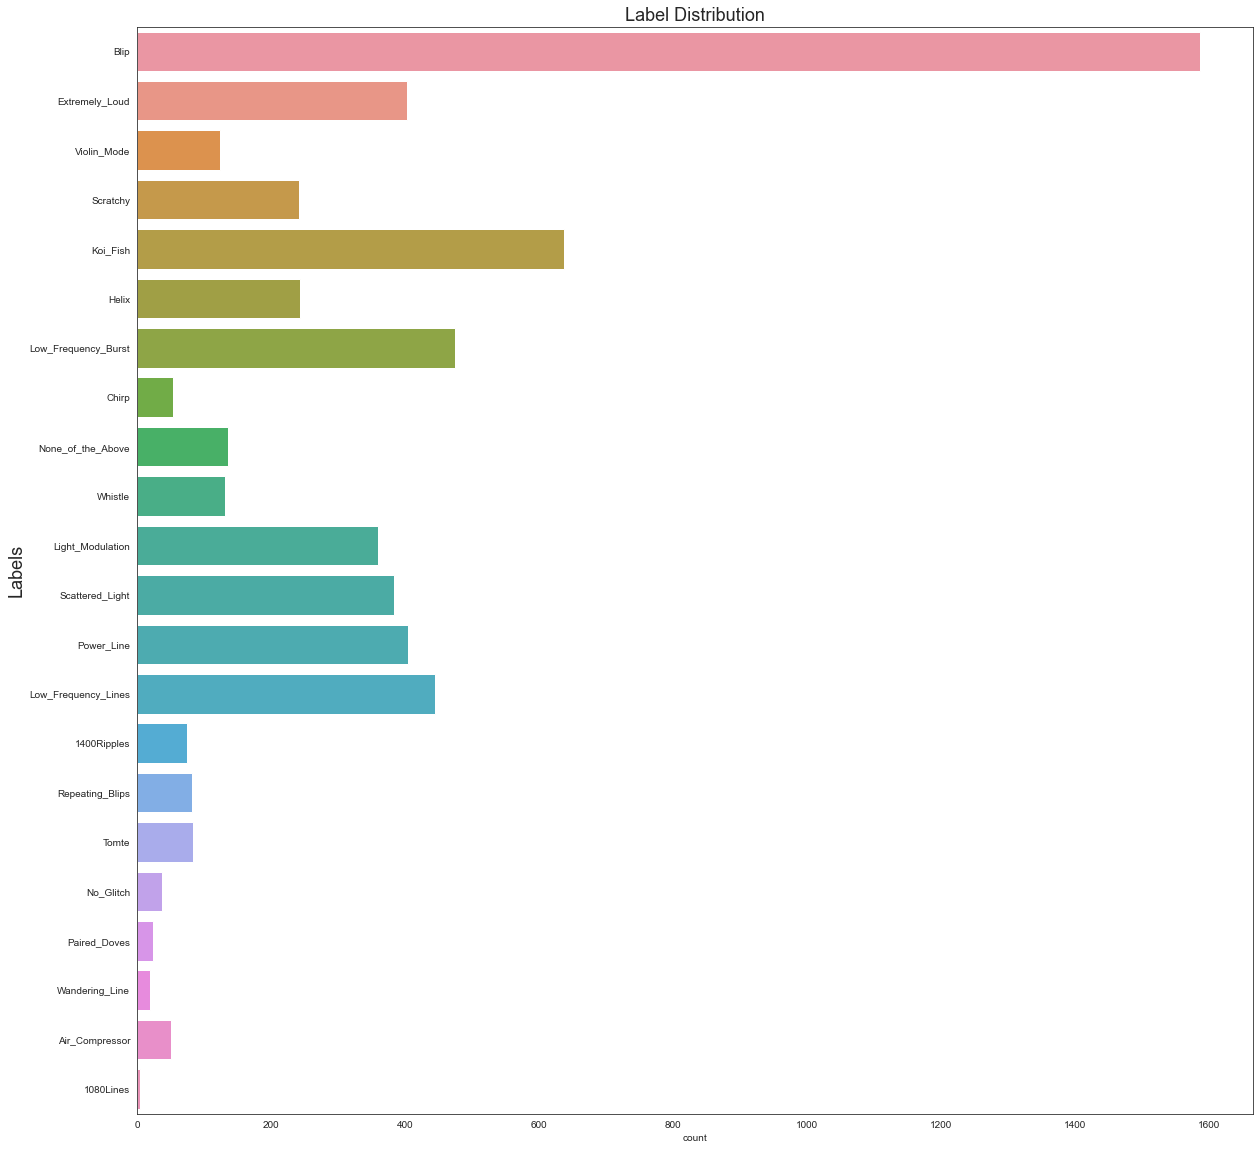

In [30]:
Figure =  plt.figure(figsize=(20,20))
plt.title("Label Distribution", fontdict={'fontsize' : 18})
sns.set_style("darkgrid")
X_labels = le.inverse_transform(labels)
sns.countplot(y=X_labels)
plt.ylabel('Labels', fontdict={'fontsize' : 18})
plt.show()

Here we notice that data is highly sqewed and we have a large number of entries for 'Blip' which is encoded as '3'

In [31]:
data.describe()

,GPStime,centralFreq,peakFreq,snr,bandwidth,duration
count,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.131849e+09,1527.440234,204.571435,187.408314,2937.869143,1.779829
std,3.171981e+06,1319.213735,375.027578,1488.282964,2663.562766,2.684282
min,1.126403e+09,9.780000,10.072000,7.501000,1.259180,0.010000
25%,1.128874e+09,256.501000,34.175000,10.360500,425.750580,0.222750
50%,1.132150e+09,1228.915000,111.128000,15.430000,2287.861206,0.767000
75%,1.134567e+09,2627.853750,183.495000,37.026500,5195.882568,2.154500
max,1.137250e+09,4615.132000,2047.106000,81178.727000,7946.482910,42.156000


As we notice here there is discrepancy in the scale of values for each column. We need to scale this data to make it useful for classification. Before that let's check out data distribution of the provided data

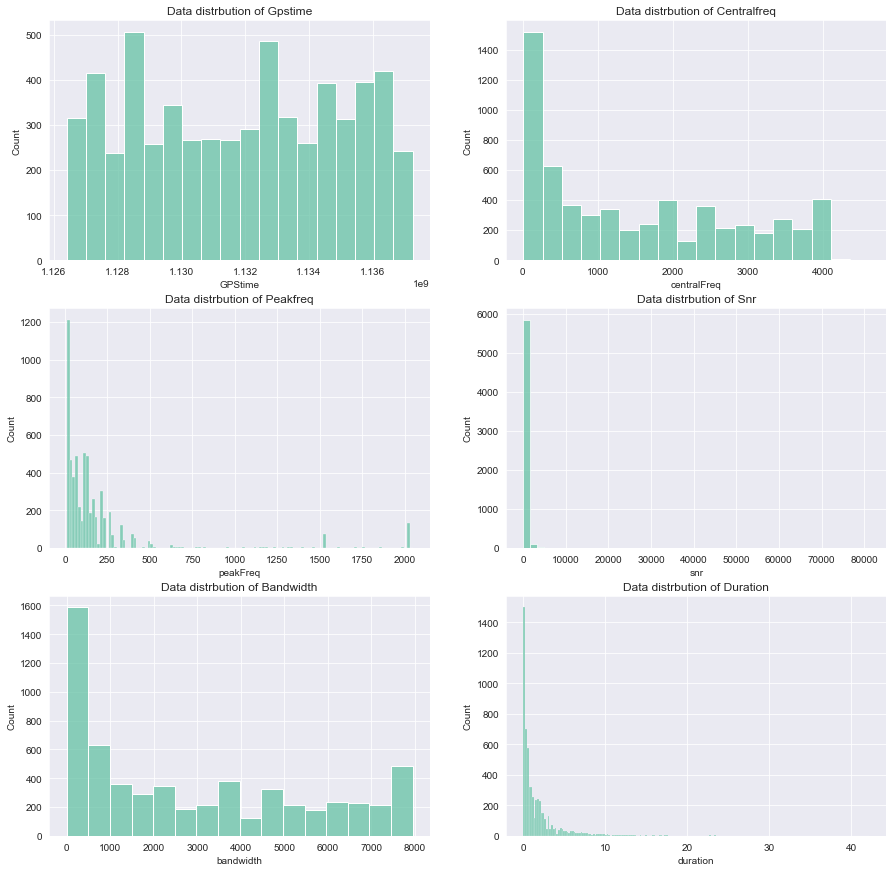

In [32]:
plt.figure(figsize=(15,15))
col = ['GPStime', 'centralFreq', 'peakFreq', 'snr', 'bandwidth', 'duration']
for i in range(6):
    plt.subplot(3,2,i+1)
    sns.set_style('darkgrid')
    title = 'Data distrbution of ' + col[i].capitalize()
    plt.title(title)
    if col[i] == 'snr':
        sns.histplot(data[col[i]], bins = 50)
    else:
        sns.histplot(data[col[i]])
    plt.xlabel(col[i])
    plt.ylabel('Count')
plt.show()

Now lets look at above graphs after log-scaling as duration and peakFreq distribution seems like they will look like gaussian in it

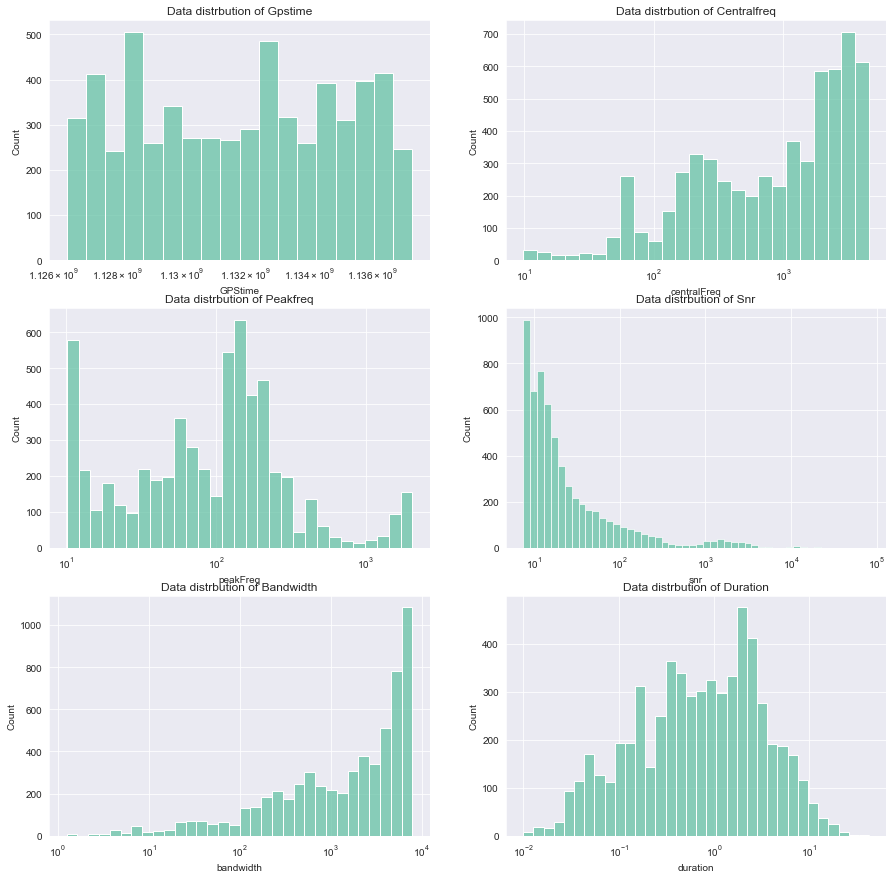

In [33]:
plt.figure(figsize=(15,15))
col = ['GPStime', 'centralFreq', 'peakFreq', 'snr', 'bandwidth', 'duration']
for i in range(6):
    plt.subplot(3,2,i+1)
    title = 'Data distrbution of ' + col[i].capitalize()
    plt.title(title)
    sns.set_style('darkgrid')
    if col[i] == 'snr':
        sns.histplot(data[col[i]], bins = 50, log_scale = True)
    else:
        sns.histplot(data[col[i]], log_scale = True)
    plt.xlabel(col[i])
    plt.ylabel('Count')
plt.show()

Now let's come to the topic we were discussing before checking out the data, the scaling of data. There are 3 general ways in which data can be prepared for classification machine learning, i.e. Scaling, Transformation or Normalization. Scaling is useful when our data needs to follow a Gaussian Distribution and Normalization is helpful when it does not and Transformation is used for transforming data to another form which can be better used by the classification algorithm. Here our data does not seem to follow Gaussian distribution but still lets apply the scaling techniques, transformation tehcniques. But a thing we have note in our data is that it is skewed. It is generally good to provide a not skewed data for models like SVC, which we are going to use, so we choose method of scaling based on that.

In the project we are using following types of <b>Scaling techniques</b>:
<ol>
    <li>Robust Scaler
</ol>
In the project we are using following types of <b>Transformation techniques</b>:
<ol>
    <li>Quantile Transformer
    <li>Quantile Transformer (Bell CUrve)
</ol>

<b>Note:</b> We are excluding <i><b>'id'</b></i> column from the data as it is unique for each unique value which we have shown below

In [34]:
print(f'Number of Unique features in the column "id" : {np.unique( data.id ).shape[0]}')

Number of Unique features in the column "id" : 6000


In [35]:
data_RS = scaler(RobustScaler(), data, col)
data_QT = scaler(QuantileTransformer(random_state = 0, output_distribution = 'uniform'), data, col)
data_QTN = scaler(QuantileTransformer(random_state = 0, output_distribution = 'normal'), data, col)

Now let's take care of the categorical data present in 'ifo' column. As the unique values in it are just 2 we are using one-hot encoding method for encoding this data. LabelEncoder would have been used if there was a lot of different values in it.

In [36]:
data_RS = pd.concat([data_RS, pd.get_dummies(data['ifo'], prefix = 'ifo')], axis=1).drop('ifo', axis=1)
data_QT = pd.concat([data_QT, pd.get_dummies(data['ifo'], prefix = 'ifo')], axis=1).drop('ifo', axis=1)
data_QTN = pd.concat([data_QTN, pd.get_dummies(data['ifo'], prefix = 'ifo')], axis=1).drop('ifo', axis=1)

Normal data for using it in Tree based classifiers

In [42]:
data_normal = pd.concat([data, pd.get_dummies(data['ifo'], prefix = 'ifo')], axis=1).drop(['ifo', 'id'], axis=1)
data_normal.head()

,GPStime,centralFreq,peakFreq,snr,bandwidth,duration,ifo_H1,ifo_L1
0,1.129517e+09,364.822,225.349,35.919,665.643311,0.250,0,1
1,1.135647e+09,3609.954,38.027,2743.555,7209.994629,13.690,1,0
2,1.129802e+09,1838.466,2025.310,16.698,3612.932861,0.375,1,0
3,1.131774e+09,2067.878,111.128,12.727,4067.436523,0.105,1,0
4,1.130969e+09,3978.111,131.921,10.926,7795.106934,2.304,0,1


Now we get rid of the the columns of datatype 'object'. Column 'id' can be deleted directly as that is unique for each entry so it is not correlation between it and labels. Column 'ifo' will be one-hot encoded and then we will remove it.

Now we can use all of the above features in our model prediction but we can do feature selection in case we have limited computational resources.

### Feature Selection

#### Feature Selection using mutual information gain

In [44]:
mutual_info_RS = pd.Series(mutual_info_classif(data_RS, labels), index = data_RS.columns).sort_values(ascending = False)
mutual_info_QT = pd.Series(mutual_info_classif(data_QT, labels), index = data_QT.columns).sort_values(ascending = False)
mutual_info_QTN = pd.Series(mutual_info_classif(data_QTN, labels), index = data_QT.columns).sort_values(ascending = False)
mutual_info_normal = pd.Series(mutual_info_classif(data_normal, labels), index = data_normal.columns).sort_values(ascending = False)

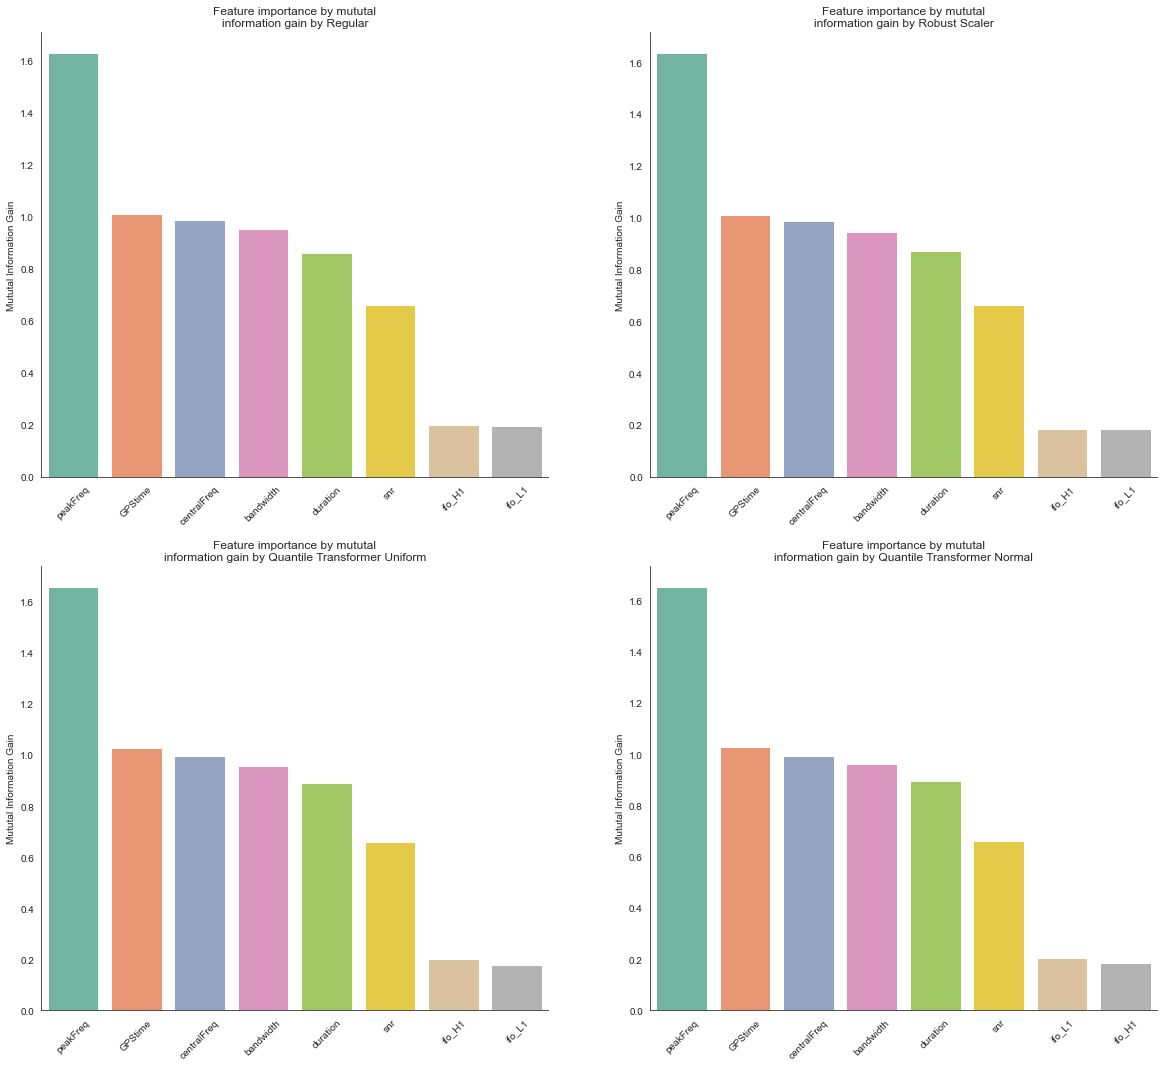

In [47]:
plts = [mutual_info_normal, mutual_info_RS, mutual_info_QT, mutual_info_QTN]
plts_name = ['Regular', 'Robust Scaler', 'Quantile Transformer Uniform', 'Quantile Transformer Normal']
plt.figure(figsize=(20,18))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.set_style('white')
    sns.set_palette('Set2')
    sns.barplot(x = plts[i].index, y = plts[i].values)
    plt.title('Feature importance by mututal\ninformation gain by ' + plts_name[i])
    plt.xticks(rotation = 45)
    sns.despine()
    plt.ylabel('Mututal Information Gain')
plt.show()

As we can see that if we wanted to reduce number of features we can remove columns 'ifo_L1' and 'ifo_H1' as they have very less mutual information gain value.

#### Feature selection using Chi-squared

As Chi-Squared feature selection method does not take negeative values only possible data we can use to check it are <i>data_QT, data_QTN</i>

In [48]:
chi_QT = pd.Series(chi2(data_QT, labels)[0], index = data_QT.columns).sort_values(ascending = False)
chi_normal = pd.Series(chi2(data_normal, labels)[0], index = data_normal.columns).sort_values(ascending = False)

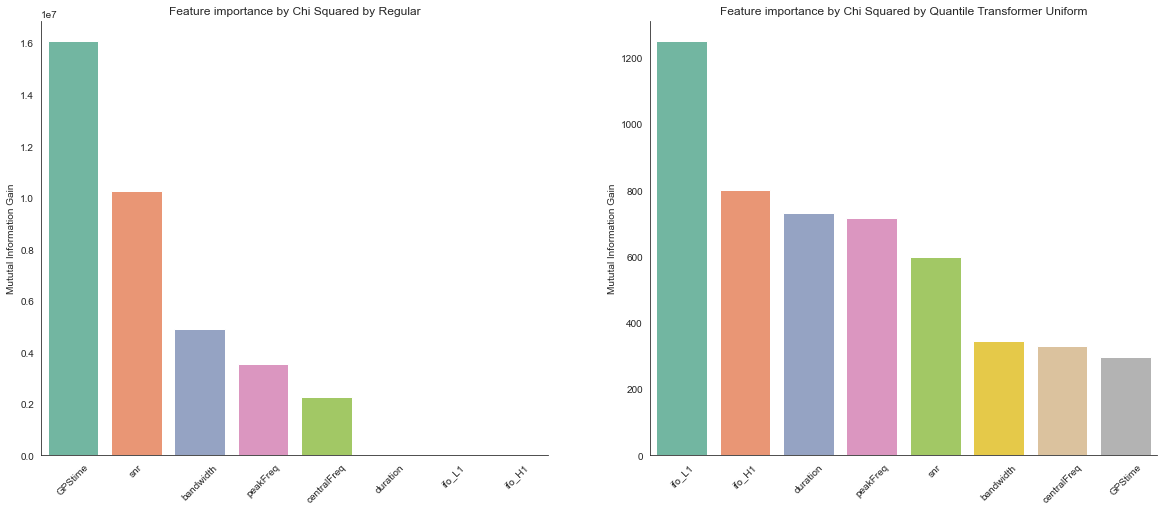

In [49]:
plts = [chi_normal, chi_QT]
plts_name = ['Regular', 'Quantile Transformer Uniform']
plt.figure(figsize=(20,8))
for i in range(2):
    plt.subplot(1, 2, i+1)
    sns.set_style('white')
    sns.set_palette('Set2')
    sns.barplot(x = plts[i].index, y = plts[i].values)
    plt.title('Feature importance by Chi Squared by ' + plts_name[i])
    plt.xticks(rotation = 45)
    sns.despine()
    plt.ylabel('Mututal Information Gain')
plt.show()

Here we see that the method <b><i>mutual_info_classif</i></b> supports the idea of dropping <i>'ifo'</i> column where are the method <b><i>chi_2</i></b> does not support it. Similar is the case for the column <i>'GPStime'</i>, <b><i>mutual_info_classif</i></b> supports its existence whereas <b><i>chi_2</i></b> asks us to delete it. So as the number of features are less we will not make any changes to the data

### Classification

#### Random Forest

<b>Note :</b> Cannot use <i>train_test_split</i> as there are couple of columns which has just 1 time appearance in class labels. 

In [51]:
no_of_split = 5
skf = StratifiedKFold(n_splits = no_of_split, shuffle = True, random_state = 0)
file_names = []
for i in range(no_of_split):
    file_names.append('random_forest_'+str(i+1))

In [68]:
file_names = []
for i in range(no_of_split):
    file_names.append('random_forest_'+str(i+1))
count = 1
random_forest_normal_scores = []
for train_index, test_index in skf.split(data,labels):
    X_train, X_test, y_train, y_test = data_normal.iloc[train_index, :], data_normal.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['none', 'sqrt', 'log2'],
    'n_estimators' : [10, 100, 1000]
    }
    model = RandomForestClassifier()
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(f1_score(y_test, pred, average='macro'))
    random_forest_normal_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Random Forest/Normal/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in random_forest_normal_scores:
    print(i, end = ', ')

0.8267661854736662
Done Split 1
0.808149086090409
Done Split 2
0.7482097203506778
Done Split 3
0.7930596436396503
Done Split 4
0.7742159834466255
Done Split 5

Scores of each split is : 0.8267661854736662, 0.808149086090409, 0.7482097203506778, 0.7930596436396503, 0.7742159834466255, 

Robust Scaler

In [23]:
random_forest_RS_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_RS.iloc[train_index, :], data_RS.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'criterion' : ['gini', 'entropy'],
        'max_features' : ['none', 'sqrt', 'log2'],
        'n_estimators' : [10, 100, 1000]
        }
    model = RandomForestClassifier()
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    random_forest_RS_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Random Forest/Robust Scaler/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in random_forest_RS_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.8244508508169558, 0.8003495049502072, 0.743100216621821, 0.792742298600163, 0.7714929113655766, 

Quantile Transformer - Uniform Distribution

In [24]:
random_forest_QT_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_QT.iloc[train_index, :], data_QT.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'criterion' : ['gini', 'entropy'],
        'max_features' : ['none', 'sqrt', 'log2'],
        'n_estimators' : [10, 100, 1000]
        }
    model = RandomForestClassifier()
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    random_forest_QT_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Random Forest/Quantile Transformer/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in random_forest_QT_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.825889684119929, 0.8059281629410282, 0.7450018991395059, 0.7901015097327487, 0.7793649589579743, 

Quantile Transformer - Normal Distribbution

In [25]:
random_forest_QTN_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_QTN.iloc[train_index, :], data_QTN.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'criterion' : ['gini', 'entropy'],
        'max_features' : ['none', 'sqrt', 'log2'],
        'n_estimators' : [10, 100, 1000]
        }
    model = RandomForestClassifier()
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    random_forest_QTN_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Random Forest/Quantile Transformer Normal/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in random_forest_QTN_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.8279485275228512, 0.8061855867471338, 0.7509015611006156, 0.7895931194481719, 0.7743959443808336, 

#### Support Vector Machines

In [38]:
file_names = []
for i in range(no_of_split):
    file_names.append('svc_'+str(i+1))

Robust Scaler

In [39]:
svc_RS_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_RS.iloc[train_index, :], data_RS.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'kernel' : ['linear', 'rbf', 'poly'],
        'degree' : [2, 3],
        'C' : [0.01, 0.1, 1, 10, 50]
        }
    model = SVC(random_state = 0)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    svc_RS_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Support Vector Machines/Robust Scaler/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in svc_RS_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.6245648845391332, 0.6087979181644697, 0.5930163868745602, 0.5958714337781486, 0.5982174508482621, 

Quantile Transformer - Uniform Distribution

In [40]:
svc_QT_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_QT.iloc[train_index, :], data_QT.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'kernel' : ['linear', 'rbf', 'poly'],
        'degree' : [2, 3],
        'C' : [0.01, 0.1, 1, 10, 50]
        }
    model = SVC(random_state = 0)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    svc_QT_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Support Vector Machines/Quantile Transformer/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in svc_QT_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.7723380154725061, 0.754805038945377, 0.7250175105473554, 0.7341042308152855, 0.7166340185682176, 

Quantile Transformer - Normal Distribbution

In [41]:
svc_QTN_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_QTN.iloc[train_index, :], data_QTN.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'kernel' : ['linear', 'rbf', 'poly'],
        'degree' : [2, 3],
        'C' : [0.01, 0.1, 1, 10, 50]
        }
    model = SVC(random_state = 0)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    svc_QTN_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Support Vector Machines/Quantile Transformer Normal/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in svc_QTN_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.7727235148609145, 0.7492345835355618, 0.7354970031686595, 0.7470116161593487, 0.6854013573763176, 

#### Bagging Classifier

In [70]:
file_names = []
for i in range(no_of_split):
    file_names.append('bagging_'+str(i+1))

Normal

In [71]:
bagging_normal_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_normal.iloc[train_index, :], data_normal.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'max_features' : [0.7, 1.0],
        'n_estimators' : [10, 100, 1000],
        'max_samples' : [0.7, 1.0]
        }
    model = BaggingClassifier(random_state = 0, n_jobs= -1)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    bagging_normal_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Bagging Classifier/Normal/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in bagging_normal_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.8365370080558134, 0.8231907337438344, 0.7486234718650551, 0.8033784420368469, 0.7724516354903588, 

Robust Scaler

In [24]:
bagging_RS_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_RS.iloc[train_index, :], data_RS.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'max_features' : [0.7, 1.0],
        'n_estimators' : [10, 100, 1000],
        'max_samples' : [0.7, 1.0]
        }
    model = BaggingClassifier(random_state = 0, n_jobs= -1)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    bagging_RS_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Bagging Classifier/Robust Scaler/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in bagging_RS_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.8360429875687869, 0.8269225432186679, 0.7498811783314647, 0.803823062127201, 0.769299936822959, 

Quantile Transformer - Uniform Distribution

In [25]:
bagging_QT_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_QT.iloc[train_index, :], data_QT.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'max_features' : [0.7, 1.0],
        'n_estimators' : [10, 100, 1000],
        'max_samples' : [0.7, 1.0]
        }
    model = BaggingClassifier(random_state = 0, n_jobs= -1)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    bagging_QT_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Bagging Classifier/Quantile Transformer/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in bagging_QT_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.8386197936869129, 0.8284911144145458, 0.7527836776766518, 0.8036526260530668, 0.8000597636463372, 

Quantile Transformer - Normal Distribbution

In [26]:
bagging_QTN_scores = []
count = 1
for train_index, test_index in skf.split(data, labels):
    X_train, X_test, y_train, y_test = data_QTN.iloc[train_index, :], data_QTN.iloc[test_index, :], labels[train_index], labels[test_index]
    parameters = {
        'max_features' : [0.7, 1.0],
        'n_estimators' : [10, 100, 1000],
        'max_samples' : [0.7, 1.0]
        }
    model = BaggingClassifier(random_state = 0, n_jobs= -1)
    clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_macro', cv = 10, n_jobs = -1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    bagging_QTN_scores.append(f1_score(y_test, pred, average = 'macro'))
    file = open('Models/Bagging Classifier/Quantile Transformer Normal/' + file_names[count - 1] + '.sav', 'wb')
    pickle.dump(clf, file)
    file.close()
    print(f'Done Split {count}')
    count = count + 1
print('\nScores of each split is : ', end = '')
for i in bagging_QTN_scores:
    print(i, end = ', ')

Done Split 1
Done Split 2
Done Split 3
Done Split 4
Done Split 5

Scores of each split is : 0.8358448355366741, 0.8063329696814531, 0.7522335820902366, 0.8013153150828319, 0.7700670657200466, 

### Model Evaluation

#### Random Forest

Normal

Model 1 : 97.0776%
Model 2 : 96.6982%
Model 3 : 95.8993%
Model 4 : 96.6131%
Model 5 : 95.9507%


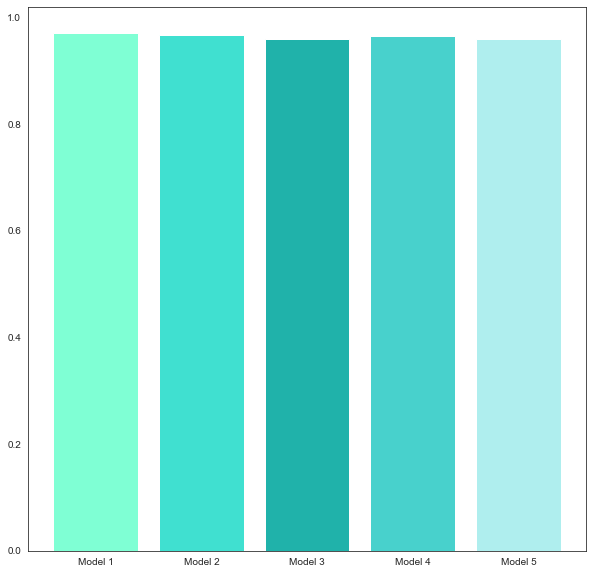

In [50]:
path = 'Models/Random Forest/Normal/'
rfNormalScores = []
modelNames = []
j = 1
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_normal)
    f1 = f1_score(labels, pred, average = 'macro')
    rfNormalScores.append(f1)
    modelNames.append('Model ' + str(j))
    print(f'Model {j} : {round(f1*100, 4)}%')
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, rfNormalScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Robust Scaler

Model 1 : 97.0656%
Model 2 : 96.6011%
Model 3 : 95.824%
Model 4 : 96.0727%
Model 5 : 95.9153%


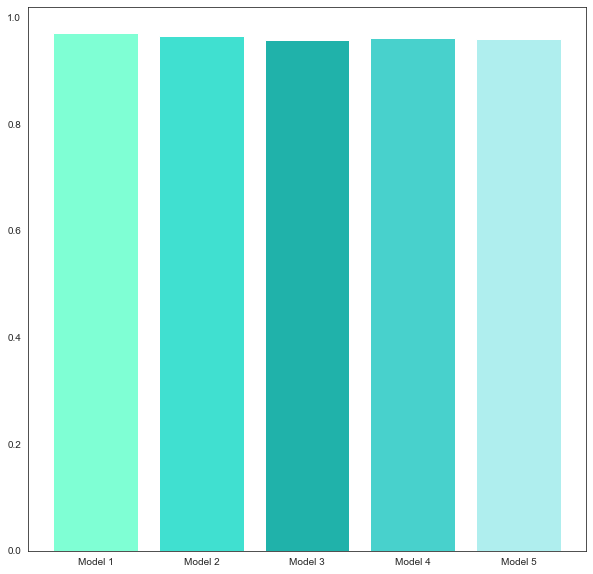

In [51]:
path = 'Models/Random Forest/Robust Scaler/'
rfRsScores = []
modelNames = []
j = 1
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_RS)
    f1 = f1_score(labels, pred, average = 'macro')
    rfRsScores.append(f1)
    modelNames.append('Model ' + str(j))
    print(f'Model {j} : {round(f1*100, 4)}%')
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, rfRsScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Quantile transform Uniform

Model 1 : 97.0304%
Model 2 : 96.6946%
Model 3 : 95.8444%
Model 4 : 96.5029%
Model 5 : 96.0059%


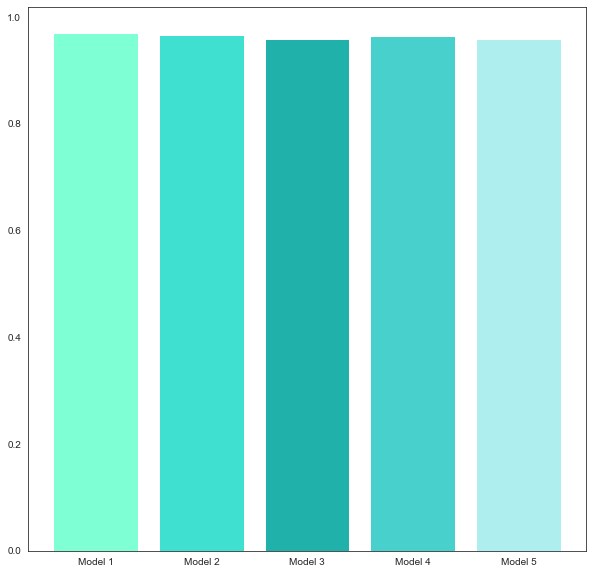

In [52]:
path = 'Models/Random Forest/Quantile Transformer/'
j = 1
rfQtScores = []
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_QT)
        f1 = f1_score(labels, pred, average = 'macro')
    rfQtScores.append(f1)
    print(f'Model {j} : {round(f1*100, 4)}%')
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, rfQtScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Quantile Transform Normal

Model 1 : 97.0698%
Model 2 : 96.6842%
Model 3 : 95.9328%
Model 4 : 96.5071%
Model 5 : 95.9621%


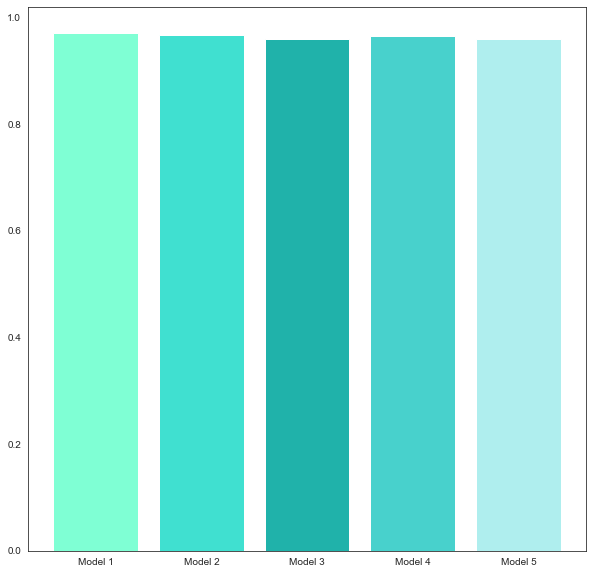

In [53]:
path = 'Models/Random Forest/Quantile Transformer Normal/'
j = 1
rfQtnScores = []
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_QTN)
        f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {round(f1*100, 4)}%')
    rfQtnScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, rfQtnScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

#### Support Vector Machines

Robust Scaler

Model 1 : 61.8277%
Model 2 : 60.294%
Model 3 : 62.1419%
Model 4 : 62.6074%
Model 5 : 64.498%


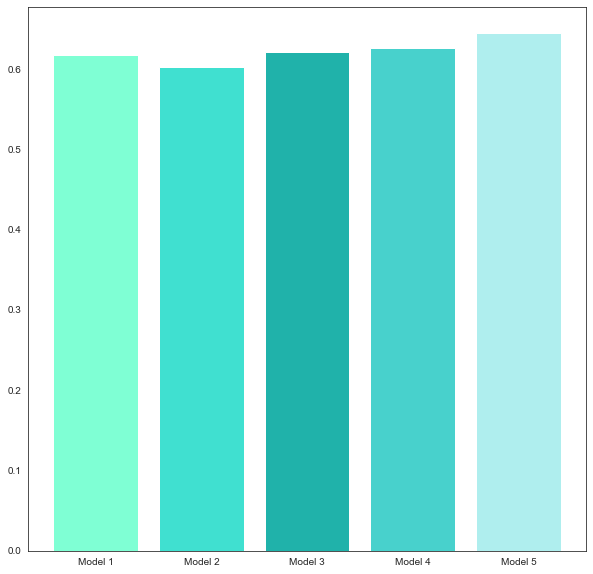

In [54]:
path = 'Models/Support Vector Machines/Robust Scaler/'
svmRsScores = []
j = 1
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_RS)
        f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {round(f1*100, 4)}%')
    svmRsScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, svmRsScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Quantile Transform Uniform

Model 1 : 84.2812%
Model 2 : 80.6318%
Model 3 : 80.5988%
Model 4 : 82.9653%
Model 5 : 80.282%


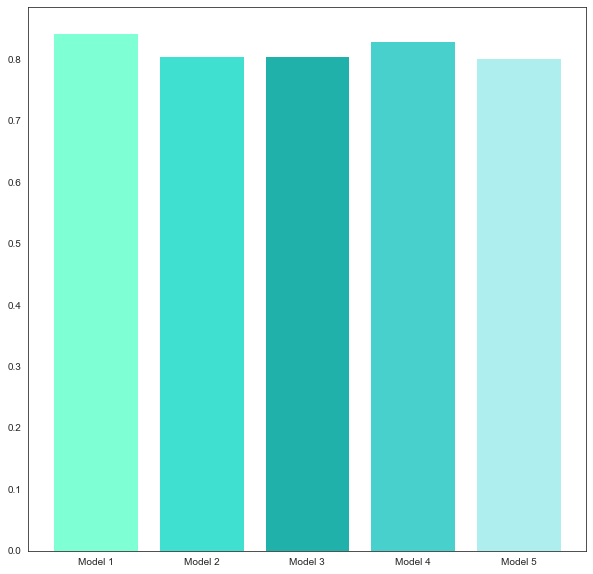

In [55]:
path = 'Models/Support Vector Machines/Quantile Transformer/'
svmQtScores = []
j = 1
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_QT)
        f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {round(f1*100, 4)}%')
    svmQtScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, svmQtScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Quantile Transform Normal

Model 1 : 82.9134%
Model 2 : 82.707%
Model 3 : 82.6249%
Model 4 : 83.0661%
Model 5 : 81.6803%


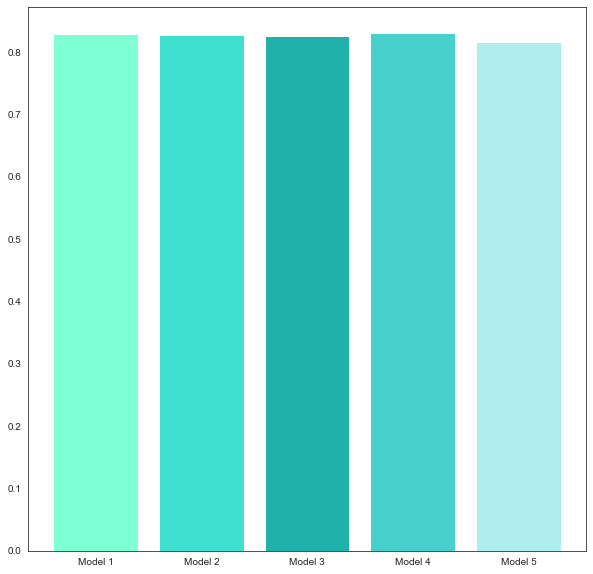

In [56]:
path = 'Models/Support Vector Machines/Quantile Transformer Normal/'
j = 1
svmQtnScores = []
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_QTN)
        f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {round(f1*100, 4)}%')
    svmQtnScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, svmQtnScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

#### Bagging Classifier

Normal

Model 1 : 97.2165%
Model 2 : 96.9492%
Model 3 : 95.9203%
Model 4 : 96.8098%
Model 5 : 95.999%


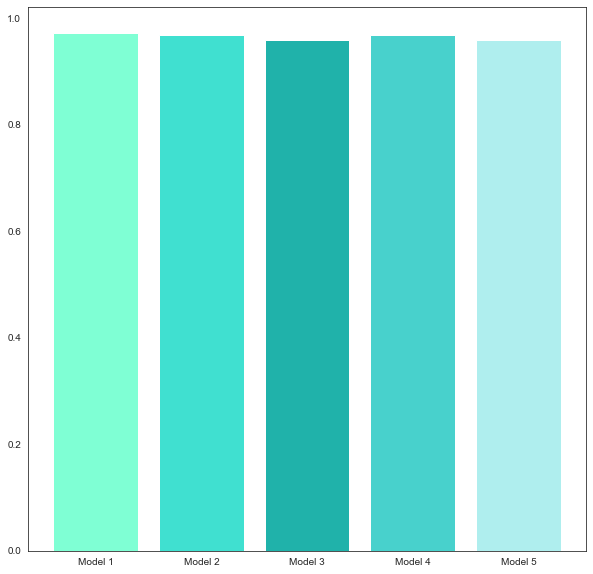

In [57]:
path = 'Models/Bagging Classifier/Normal/'
bcNormalScores = []
modelNames = []
j = 1
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_normal)
    f1 = f1_score(labels, pred, average = 'macro')
    bcNormalScores.append(f1)
    modelNames.append('Model ' + str(j))
    print(f'Model {j} : {round(f1*100, 4)}%')
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, bcNormalScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Robust Scaler

Model 1 : 97.195%
Model 2 : 96.9797%
Model 3 : 95.9374%
Model 4 : 96.8209%
Model 5 : 95.9242%


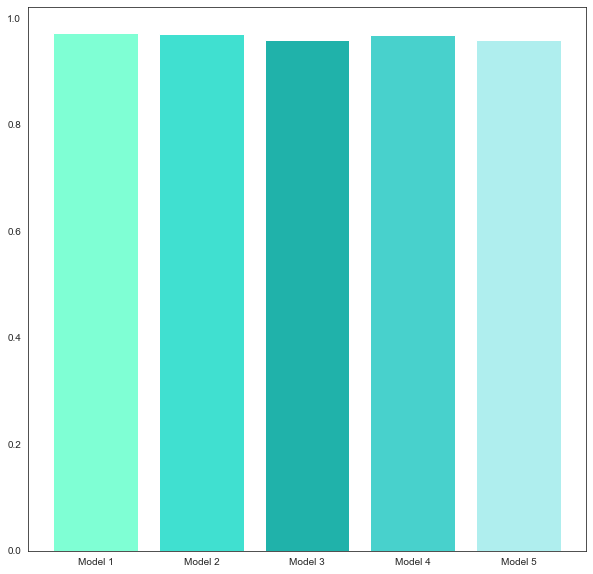

In [58]:
path = 'Models/Bagging Classifier/Robust Scaler/'
j = 1
bcRsScores = []
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_RS)
        f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {round(f1*100, 4)}%')
    bcRsScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, bcRsScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Quantile Transformer Unifrom

Model 1 : 0.9724702577073269
Model 2 : 0.9700999525867313
Model 3 : 0.9600210012618902
Model 4 : 0.9681841136770184
Model 5 : 0.9614164031622707


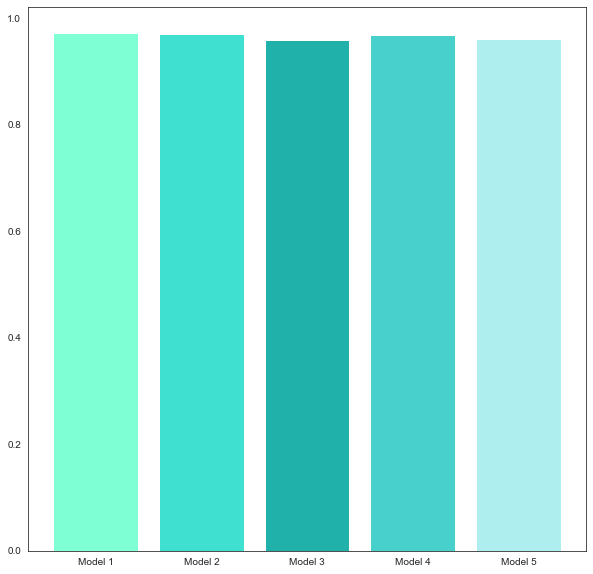

In [59]:
path = 'Models/Bagging Classifier/Quantile Transformer/'
j = 1
bcQtScores = []
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_QT)
        f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {f1}')
    bcQtScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, bcQtScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

Quantile Transformer Normal

Model 1 : 97.247%
Model 2 : 97.01%
Model 3 : 96.0021%
Model 4 : 96.8184%
Model 5 : 96.1416%


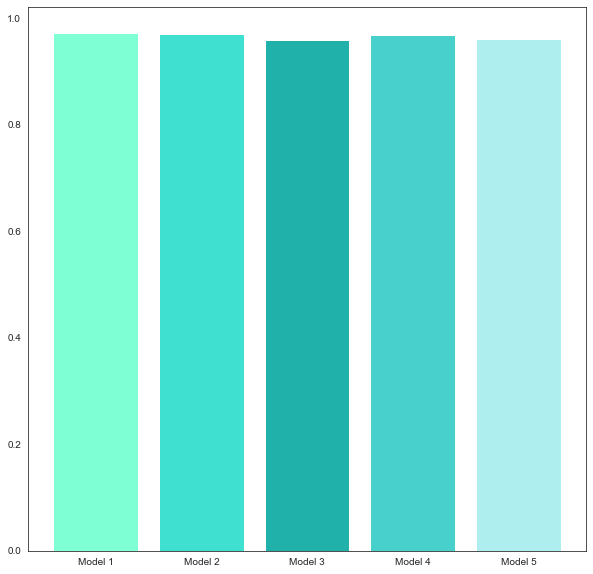

In [60]:
path = 'Models/Bagging Classifier/Quantile Transformer/'
j = 1
bcQtnScores = []
for i in os.listdir(path):
    model_path = path + str(i)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        pred = model.predict(data_QT)
    f1 = f1_score(labels, pred, average = 'macro')
    print(f'Model {j} : {round(f1*100, 4)}%')
    bcQtnScores.append(f1)
    j += 1
Figure = plt.figure(figsize=(10,10))
plt.bar(modelNames, bcQtnScores, color=['aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise', 'paleturquoise'])
plt.show()

By the F1 Major Score we can see that Bagging Classifier with Quantile Normal Transform model 1 or Quantile Transform Uniform model 1 is the best for our data.

In [61]:
df_scores = pd.DataFrame({'Model' : ['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Support Vector Machines', 'Support Vector Machines', 'Support Vector Machines', 'Bagging Classifier', 'Bagging Classifier', 'Bagging Classifier', 'Bagging Classifier'], 'Scaler' : ['Normal', 'Robust Scaler', 'Quantile Transform Uniform', 'Quantile Trnasform Normal', 'Robust Scaler', 'Quantile Transform Uniform', 'Quantile Trnasform Normal', 'Normal', 'Robust Scaler', 'Quantile Transform Uniform', 'Quantile Trnasform Normal'], 'Scores' : [np.max(i)*100 for i in [rfNormalScores, rfRsScores, rfQtScores, rfQtnScores, svmRsScores, svmQtScores, svmQtnScores, bcNormalScores, bcRsScores, bcQtScores, bcQtnScores]]})
df_scores

,Model,Scaler,Scores
0,Random Forest,Normal,97.077589
1,Random Forest,Robust Scaler,97.065563
2,Random Forest,Quantile Transform Uniform,97.030422
3,Random Forest,Quantile Trnasform Normal,97.069758
4,Support Vector Machines,Robust Scaler,64.498017
5,Support Vector Machines,Quantile Transform Uniform,84.281202
6,Support Vector Machines,Quantile Trnasform Normal,83.066130
7,Bagging Classifier,Normal,97.216452
8,Bagging Classifier,Robust Scaler,97.195032
9,Bagging Classifier,Quantile Transform Uniform,97.247026


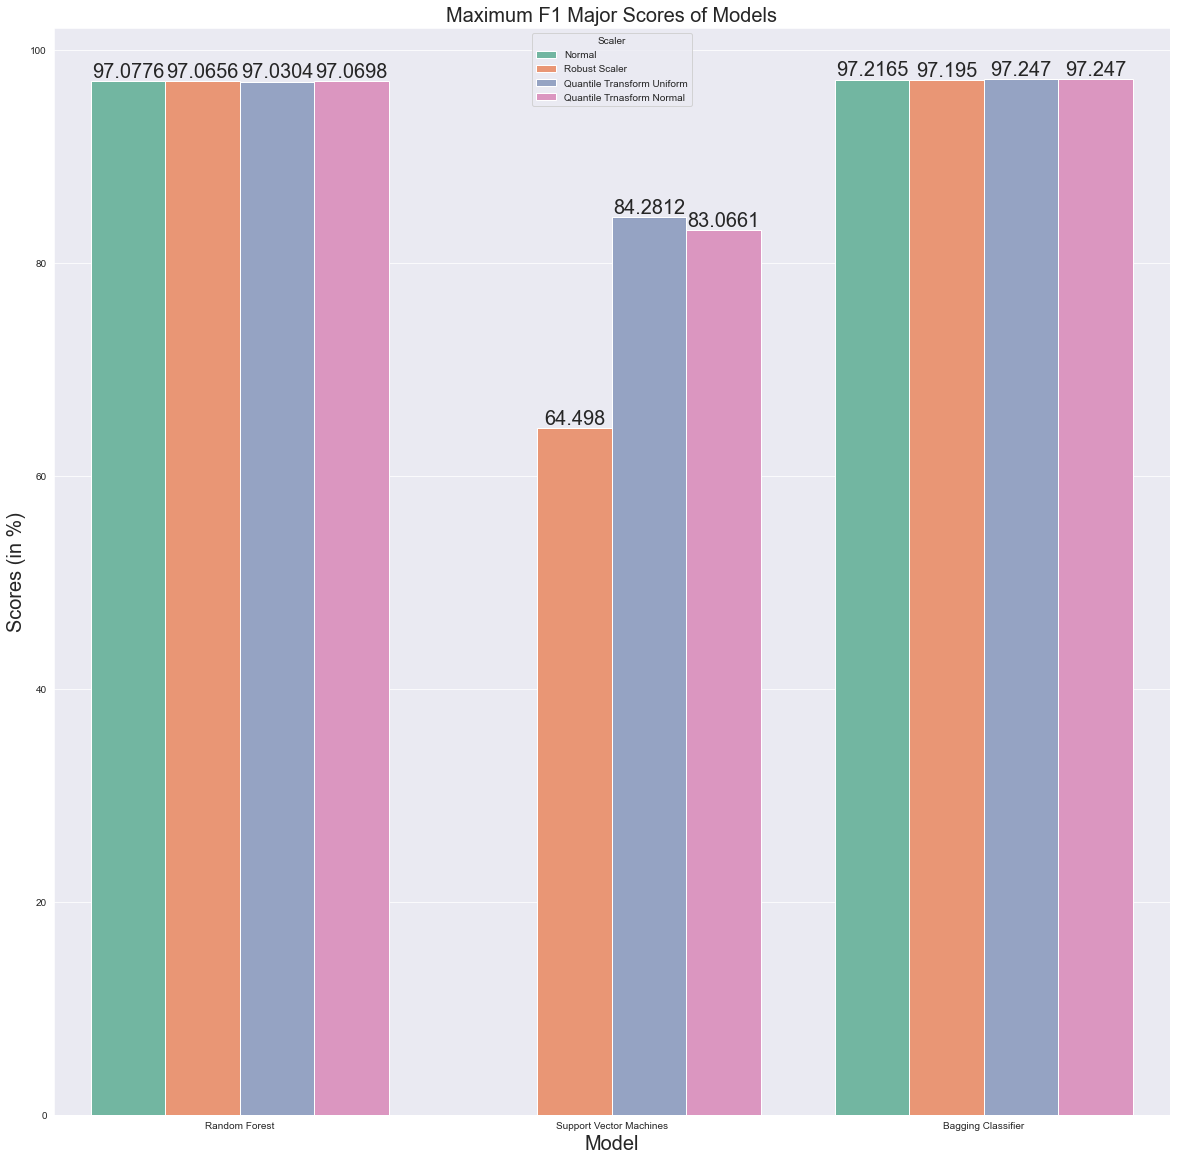

In [62]:
Figure = plt.figure(figsize=(20,20))
sns.set_style('darkgrid')
ax = sns.barplot(x = 'Model', y = 'Scores', hue = 'Scaler', data = df_scores)
ax.bar_label(ax.containers[0], size = 20)
ax.bar_label(ax.containers[1], size = 20)
ax.bar_label(ax.containers[2], size = 20)
ax.bar_label(ax.containers[3], size = 20)
plt.title('Maximum F1 Major Scores of Models', fontdict = {'fontsize' : 20})
plt.xlabel('Model', fontdict = {'fontsize' : 20})
plt.ylabel('Scores (in %)', fontdict = {'fontsize' : 20})
plt.show()

### Generating Test Labels

##### Loading test data

In [24]:
test = pd.read_csv('data/glitch_tst_data.csv')
col = ['GPStime', 'centralFreq', 'peakFreq', 'snr', 'bandwidth', 'duration']
test_QT = scaler(QuantileTransformer(random_state = 0, output_distribution = 'uniform'), test.drop(['id'], axis = 1), col)
test_QT = pd.concat([test_QT, pd.get_dummies(test_QT['ifo'], prefix = 'ifo')], axis=1).drop(['ifo'], axis=1)

,GPStime,centralFreq,peakFreq,snr,bandwidth,duration,ifo_H1,ifo_L1
0,0.463964,0.791291,0.259009,0.822823,0.794294,0.722973,1,0
1,0.539039,0.469970,0.895646,0.328829,0.472973,0.084084,1,0
2,0.168168,0.247748,0.603604,0.075075,0.180931,0.052553,0,1
3,0.564565,0.611111,0.638889,0.453453,0.624625,0.144144,1,0
4,0.548048,0.468468,0.707207,0.189189,0.480480,0.243243,1,0


#### Loading Model

In [25]:
with open('Models/Bagging Classifier/Quantile Transformer/bagging_1.sav', 'rb') as f:
    model = pickle.load(f)

#### Predicting and writing to file

In [31]:
prediction = model.predict(test_QT)
labels = le.inverse_transform(prediction)
with open('meet_maratha_labels.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')